# fast.ai           Lesson 1

In [1]:
%matplotlib inline

In [2]:
#path = "data/dogscats/"
path = "data/dogscats/sample/"

In [3]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
#custom functions
import utils; reload(utils)
from utils import plots

Using TensorFlow backend.


### Use a pretrained VGG model with our Vgg16 class

In [4]:
# set the batch size, no larger than 64 is recommended
batch_size=16

In [5]:
# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [6]:
vgg = Vgg16()
# Grab a few images at a time for training and validation
# They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train/', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid/', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, epochs=1)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/1
10/10 [==============================] - 379s - loss: 1.1789 - acc: 0.5938    


### Using VGG16 for basic image recognition

In [10]:
vgg = Vgg16()

In [11]:
batches = vgg.get_batches(path+'train', batch_size=4)

Found 160 images belonging to 2 classes.


In [12]:
imgs,labels = next(batches)

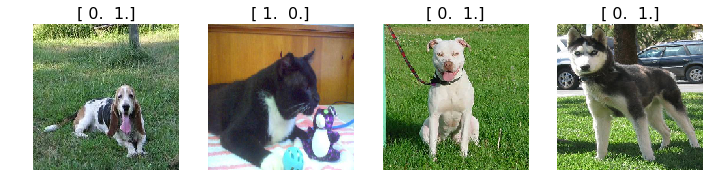

In [13]:
plots(imgs, titles=labels)

In [14]:
vgg.predict(imgs, True)

(array([ 0.4118,  0.4086,  0.4906,  0.3354], dtype=float32),
 array([251, 361, 180, 368]),
 [u'dalmatian', u'skunk', u'American_Staffordshire_terrier', u'gibbon'])

### Use our Vgg16 class to finetune a Dogs vs Cats model

In [15]:
batch_size=16

In [16]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [17]:
vgg.finetune(batches)

In [44]:
vgg.fit(batches, val_batches, epochs=1)

Epoch 1/1
40/40 [==============================] - 395s - loss: 0.5742 - acc: 0.8188   


## Create a VGG model from scratch in Keras

In [35]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [21]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

### Model Creation



Creating the model involves creating the model architecture, and then loading the model weights into that architecture. We will start by defining the basic pieces of the VGG architecture.
VGG has just one type of convolutional block, and one type of fully connected ('dense') block. Here's the convolutional block definition:

In [36]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Conv2D(filters, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

and here's the fully-connected definition:

In [31]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

When the VGG model was trained in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Furthermore, their software that expected the channels to be in B,G,R order, whereas Python by default uses R,G,B. We need to preprocess our data to make these two changes, so that it is compatible with the VGG model:

In [32]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

Now we're ready to define the VGG model architecture.  
Note--Convolution layers are for finding patterns in images and Dense (fully connected) layers are for combining patterns across an image

In [33]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [37]:
model = VGG_16()

As well as the architecture, we need the weights that the VGG creators trained. The weights are the part of the model that is learnt from the data, whereas the architecture is pre-defined based on the nature of the problem.

Downloading pre-trained weights is much preferred to training the model ourselves, since otherwise we would have to download the entire Imagenet archive, and train the model for many days! It's very helpful when researchers release their weights, as they did here.


In [38]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

### Getting imagenet predictions

The setup of the imagenet model is now complete, so all we have to do is grab a batch of images and call predict() on them.

In [39]:
batch_size = 4

Keras provides functionality to create batches of data from directories containing images; all we have to do is to define the size to resize the images to, what type of labels to create, whether to randomly shuffle the images, and how many images to include in each batch. We use this little wrapper to define some helpful defaults appropriate for imagenet data:

In [40]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

From here we can use exactly the same steps as before to look at predictions from the model.

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


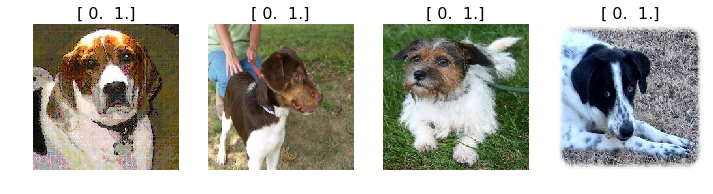

In [41]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

The VGG model returns 1,000 probabilities for each image, representing the probability that the model assigns to each possible imagenet category for each image. By finding the index with the largest probability (with np.argmax()) we can find the predicted label.

In [42]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [43]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  2.5843e-06   9.3238e-04   2.7354e-04   5.3503e-05   4.8188e-05]

Predictions prob/class: 
  0.2113/barn_spider
  0.2091/German_short-haired_pointer
  0.3976/Shih-Tzu
  0.7828/Great_Dane
